In [1]:
BATCH_SIZE = 1
N_CORES = 8
LOAD_MEM = False
TEST = True

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import rasterio

import random

import os, os.path

from tensorflow.python.keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

import spectral

from scipy import sparse

import scipy.io as sio

import spectral.io.envi as envi

import cv2

import asyncio 

import scipy 
from scipy import io, misc
import imageio

from AdvGAN import dataset, models, utils, activations, gan, print_functions

from potsdam_dataset_v1 import Potsdam_dataset_tf

Using TensorFlow backend.


AdvGAN library
AdvGAN library


# Datasets

In [3]:
LABEL_DETAILS = [('No data', (0,0,0)),
          ('Impervious surfaces', (255, 255, 255)),
          ('Building', (0, 0, 255)),
          ('Low vegetation', (0, 255, 255)),
          ('Tree', (0,255,0)),
          ('Car', (255,255,0)),
          ('Clutter/background', (255,0,0))]

LABELS = [l[0] for l in LABEL_DETAILS]
N_CLASSES = len(LABELS) # Number of classes

palette = {v: k[1] for v,k in enumerate(LABEL_DETAILS)}

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d


In [4]:
def misclassif_checking(lbl_a, lbl_b, lbl_gt, searched=4):
    
    colors = np.array([[0,0,0], [255,0,0], [0,255,0]], dtype=int)
    
    only_lbl_a = lbl_a * lbl_gt
    only_lbl_b = lbl_b * lbl_gt
    
    s = np.shape(lbl_gt)
    img = np.zeros((s[0], s[1], 3), dtype=int)
    
    for i in range(len(only_lbl_a)):
        for j in range(len(only_lbl_a[i])):
            if only_lbl_a[i, j] == searched:
                only_lbl_a[i, j] = 1
            else:
                only_lbl_a[i, j] = 0
                
            if only_lbl_b[i, j] == searched:
                only_lbl_b[i, j] = 1
            else:
                only_lbl_b[i, j] = 0
            
    dif = np.array(only_lbl_a - only_lbl_b)
    #dif[64,64] = -1
        
    for i in range(len(img)):
        for j in range(len(img[i])):
            img[i,j] = colors[dif[i,j]]

    
    return img

In [5]:
generator = models.unet_gen_deep(img_size=128, bs=BATCH_SIZE, nb_channels=4, scope_name="generator", ignore_mask = True,
                            use_bias=False, use_sn=False, h=activations.lrelu(0.2), default_reuse=False, o=tf.tanh)

discriminator = models.mask_disc_deep(hiddens_dims=[64,128,256,512], name="discriminator", default_reuse=True,
                              default_train=False,use_bias=False, use_sn=False)

In [6]:
class Classifier:
    
    def  __init__(self, path):
        self.path = path
        
    def load_model(self):
        json_file = open(self.path+'.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = model_from_json(loaded_model_json)
        
    def load_weights(self):
        self.model.load_weights(self.path+".h5")

    def predict(self, X):
        return self.model(X)
    
classifier = Classifier('saved_models/Potsdam/segnet')

In [7]:
# G_OPTIMIZER
g_optim = {'name': 'RMSProp', 'learning_rate': 5e-5}

# D_OPTIMIZER
d_optim = {'name': 'RMSProp', 'learning_rate': 1e-4}

data = Potsdam_dataset_tf((1, 128, 128, 4), BATCH_SIZE, N_CORES, load_on_mem=LOAD_MEM, test=TEST)

print(data)

# Build option for CFG (options not set in cfg are set with default values)
advgan = gan.make_gan('cfg/potsdam.cfg')

advgan.set_generator(generator)
    
advgan.set_discriminator(discriminator)

advgan.set_classifier(classifier)

advgan.set_dataset(data)
advgan.set_batch_size(BATCH_SIZE)

# Need to build before train
advgan.build_model(reset_graph=True)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
meh





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` i

In [8]:
class Classifier:
    
    def  __init__(self, path):
        self.path = path
        
    def load_model(self):
        json_file = open(self.path+'.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = model_from_json(loaded_model_json)
        
    def load_weights(self):
        self.model.load_weights(self.path+".h5")

    def predict(self, X):
        return self.model.predict(X)

In [9]:
classifier = Classifier('saved_models/Potsdam/segnet')
classifier.load_model()
classifier.load_weights()

In [10]:
if TEST:
    gen_datas = data.get_tests()
else:
    gen_datas = data.generate_windows()

In [11]:
batchsize = 1
z_size = [128, 128, 1]

In [19]:
p, x, l, m, _, _, _ = next(gen_datas)
x = x/127.5 - 1

x = [x]
m = [m]
m = np.expand_dims(m, -1)

size = [batchsize] + z_size
rand = np.ones(len(size), dtype=np.int)
rand[-1] = size[-1]
rand[0] = size[0]
ones = np.ones(size, dtype=np.float)
noise = ones*np.random.normal(-1., 1., size=rand)

g = advgan.load_and_generate_mask('AdvGAN_potsdam_car_labels', data=x, noise=noise, mask=m, batch_size=batchsize,
                                 restore_meta=True)

idx = 0

preds_x = np.argmax(classifier.predict([x]), 3)
preds_g = np.argmax(classifier.predict([g]), 3)

INFO:tensorflow:Restoring parameters from data/Potsdam_save/AdvGAN_potsdam_car_labels.ckpt


In [20]:
preds_g = np.argmax(classifier.predict(g), 3)

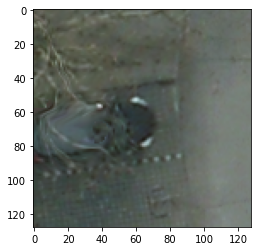

In [21]:
plt.imshow(np.array((x[0][:, :, :3]+1)*127.5).astype(int))

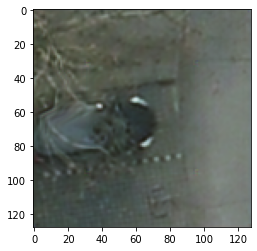

In [22]:
plt.imshow(np.array((g[0][:, :, :3]+1)*127.5).astype(int))

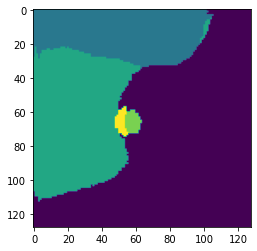

In [23]:
plt.imshow(preds_x[0])

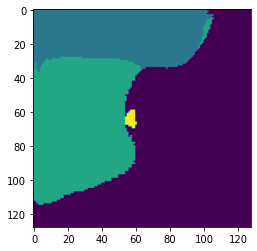

In [24]:
plt.imshow(preds_g[0])

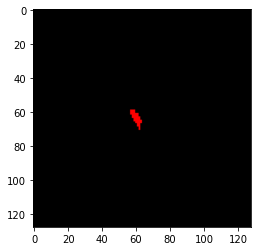

In [25]:
plt.imshow(misclassif_checking(preds_x[0], preds_g[0], l))